In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import sys
import hardware_control.wx_programs as wx
import hardware_control.bnc as bnc
from classes.generator import *
from hardware_control.hardware_config import *
from experiment_configuration.values import *
from classes.qubit_class import *
import daq.daq_programs_homo as daq
import seaborn as sns
import standard_sequences.rabi as rabi
import analysis.plotting as plotting
import analysis.analysis as analysis

In [2]:
q1 = Qubit(q1_dict, readout_dict)
q2 = Qubit(q2_dict, readout_dict)
readout = Readout(readout_dict)
print(f"{q1}\n{q2}")
 # -0.08

Qubit(mixer_offset_ef=6, qubit_thr=[-10000, -600], mixer_offset_ge=2.5, RO_LO=6.6247, ro_amp=0.37, ge_amp=1.01, ge_ssm=-0.1144, ef_time=44, ef_ssm=-0.2568, ROIF=0.10268999999999995, ge_time=77, ef_half_amp_y=1.348, IQ_angle=60, ef_amp=1.5, RO_IF=None, ro_freq=6.72739, RO_LO_pwr=16, qubit_id=q1, ef_half_time=25, ef_half_amp_x=1.348, ro_dur=5000)
Qubit(mixer_offset_ef=None, qubit_thr=[-10000, 1900], mixer_offset_ge=None, RO_LO=6.6247, ro_amp=0.5, ge_amp=0.8, ge_ssm=-0.154, ef_time=None, ef_ssm=-0.2962, ROIF=0.030840000000000423, ge_time=74, ef_half_amp_y=None, IQ_angle=25, ef_amp=1, RO_IF=None, ro_freq=6.65554, RO_LO_pwr=16, qubit_id=q2, ef_half_time=None, ef_half_amp_x=None, ro_dur=5000)


In [3]:
wx_addr = wx.get_wx_address()
main_directory = r"C:\Users\quantum1\Documents"
save_dir = rf"{main_directory}\Python Scripts\Important Blue Fridge Python Files\New\nonlinear_QM\data"
target_bnc_address_6 = "USB0::0x03EB::0xAFFF::411-433500000-0753::INSTR"
bnc.set_bnc_output(
    general_vals_dict["qubit_bnc"], power_dBm=13, bnc_addr=target_bnc_address_6
)
bnc.set_bnc_output(
    readout_dict["RO_LO"],
    power_dBm=readout_dict["RO_LO_pwr"],
    bnc_addr=bnc_address["target_bnc_black"],
)
bnc.set_bnc_output(
    general_vals_dict["TWPA_freq"],
    general_vals_dict["TWPA_pwr"],
    bnc_addr=bnc_address["big_agilent"],
)

In [4]:
# phase_offset=6
# rabi.test_rabi_ge(q1, q2, general_vals_dict, 1,phase_offset )
# wx.wx_set_and_amplitude_and_offset(
#         amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
#     )
# values = daq.run_daq_het_2q(
#         q1, q2, num_patterns=1, num_records_per_pattern=1000, verbose=True
#     )

In [5]:
# values = daq.run_daq_het_2q(
#         q2, q1, num_patterns=1, num_records_per_pattern=5000, verbose=True
#     )

In [ ]:
def run_rabi(
    q1,
    q2,
    general_vals_dict,
    num_steps: int,
    sweep_time: float,
    reps: int,
):
    """
    Runs a single instance of the geRabi experiment
    and processes the resulting IQ data to compute probabilities vs. time.

    Returns:
        df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as
                                np.linspace(0, sweep_time/1000, num_steps)) and which has
                                columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
                                of the f, e, and g states respectively.
    """
    # Run the experiment
    rabi.rabi_ge(q1, q2, general_vals_dict, num_steps, sweep_time)
    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=True
    )

    # Retrieve raw IQ data from the acquired values
    I1_raw = values.rec_readout_1[0]
    Q1_raw = values.rec_readout_1[1]
    I2_raw = values.rec_readout_2[0]
    Q2_raw = values.rec_readout_2[1]

    # Build a DataFrame from the IQ data for classification
    IQ_df = pd.DataFrame({"I1": I1_raw, "Q1": Q1_raw, "I2": I2_raw, "Q2": Q2_raw})
    return values, IQ_df

In [7]:
num_steps = 101
reps = 2000
sweep_time = 100
values, IQ_df = run_rabi(q1,q2,general_vals_dict,num_steps, sweep_time, reps)

TypeError: unsupported operand type(s) for +: 'int' and 'NoneType'

Q


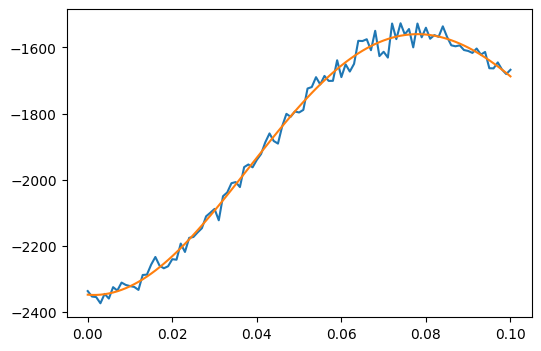



  freq: 6.5353854068029875 +/- 0.14794629640534426
 gamma: 3.0518858710223133 +/- 1.9789994225178198
   amp: -442.95977502633866 +/- 29.975231412891233
 phase: 82.22084418588143 +/- 6.013275036586807
offset: -1908.0666293877657 +/- 29.008616306648502
pi_pulse time: 0.07650658207234828 +/- 0.14794629640534426
π_ge time = 76.50658207234828 ns


In [ ]:
IQ_df = plotting.get_IQ_averages(values)
Q = IQ_df["Q1"]
I = IQ_df["I1"]
Qrange = abs(np.max(Q) - np.min(Q))
Irange = abs(np.max(I) - np.min(I))
if Qrange > Irange:
    print("Q")
    times = np.linspace(0, sweep_time / 1000, num_steps)
    pi_ge_fit_vals, _, _, _ = analysis.fit_sine_decay(
        times, Q, guess_vals=[11, 0.3, np.abs(np.max(Q) - np.min(Q)), 38, Q[0]]
    )
    pi_ge = abs((1 / 2 / pi_ge_fit_vals[0]) * 1000)
    print("\u03C0_ge time = {} ns".format(pi_ge))
else:
    print("I")
    times = np.linspace(0, sweep_time / 1000, num_steps)
    pi_ge_fit_vals, _, _, _ = analysis.fit_sine_decay(
        times, I, guess_vals=[11, 0.3, np.abs(np.max(I) - np.min(I)), 38, I[0]]
    )
    pi_ge = abs((1 / 2 / pi_ge_fit_vals[0]) * 1000)
    print("\u03C0_ge time = {} ns".format(pi_ge))